[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.288586  24.757340  23.848711  24.746232  212818400
2015-01-05  23.604334  24.137514  23.417722  24.057537  257142000
2015-01-06  23.606556  23.866481  23.244437  23.668760  263188400
2015-01-07  23.937571  24.037541  23.704304  23.815383  160423600
2015-01-08  24.857311  24.915073  24.148625  24.266371  237458000
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0322 - val_loss: 0.0030
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 1

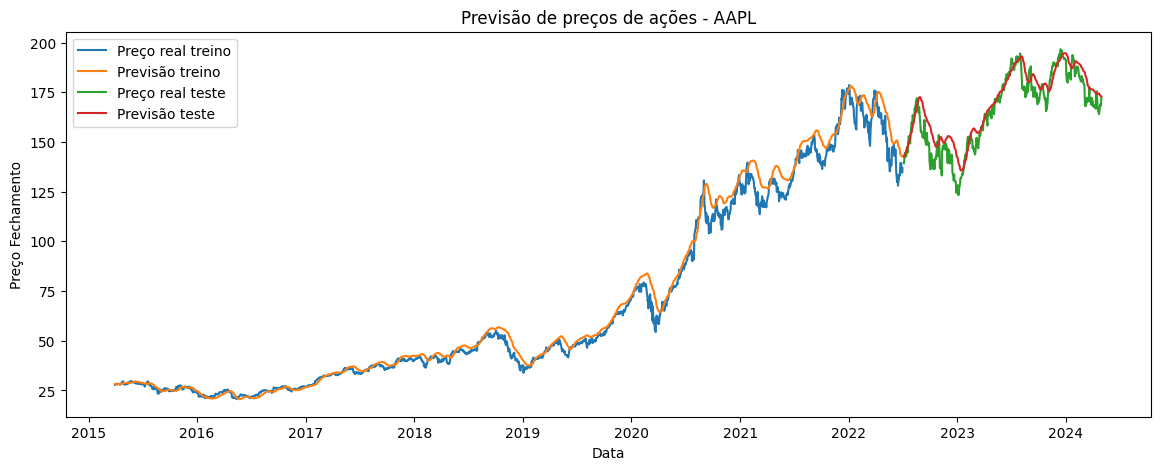

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Preço previsto para o próximo dia: 172.87


In [ ]:
# Instalar bibliotecas necessárias
!pip install yfinance tensorflow matplotlib -q

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# --- 1. Baixar dados históricos da ação ---
ticker = 'AAPL'  # Pode alterar para outro ticker válido
start_date = '2015-01-01'
end_date = '2024-05-01'

df = yf.download(ticker, start=start_date, end=end_date)
print(df.head())

# Usar a coluna 'Close' (ajustada se auto_adjust=True)
data = df['Close'].values.reshape(-1,1)

# --- 2. Normalizar os dados ---
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# --- 3. Criar sequências para treino ---
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Dividir em treino e teste (80% treino)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape para [samples, time steps, features] para LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# --- 4. Construir o modelo LSTM ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# --- 5. Treinar o modelo ---
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

# --- 6. Fazer previsões ---
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter escala para valores originais
train_predict = scaler.inverse_transform(train_predict)
Y_train_orig = scaler.inverse_transform(Y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_orig = scaler.inverse_transform(Y_test.reshape(-1,1))

# --- 7. Ajustar shapes para plotagem ---
train_predict = train_predict.reshape(-1)
Y_train_orig = Y_train_orig.reshape(-1)
test_predict = test_predict.reshape(-1)
Y_test_orig = Y_test_orig.reshape(-1)

# Garantir que os arrays tenham o mesmo tamanho para plotagem
min_train_len = min(len(train_predict), len(Y_train_orig))
train_predict = train_predict[:min_train_len]
Y_train_orig = Y_train_orig[:min_train_len]

min_test_len = min(len(test_predict), len(Y_test_orig))
test_predict = test_predict[:min_test_len]
Y_test_orig = Y_test_orig[:min_test_len]

# --- 8. Visualizar os resultados ---
plt.figure(figsize=(14,5))

# Índices para treino e teste (ajustados para plotagem no eixo x)
train_indices = df.index[time_step:time_step+min_train_len]
test_indices = df.index[time_step+min_train_len+1:time_step+min_train_len+1+min_test_len]

plt.plot(train_indices, Y_train_orig, label='Preço real treino')
plt.plot(train_indices, train_predict, label='Previsão treino')

plt.plot(test_indices, Y_test_orig, label='Preço real teste')
plt.plot(test_indices, test_predict, label='Previsão teste')

plt.title(f'Previsão de preços de ações - {ticker}')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento')
plt.legend()
plt.show()

# --- 9. Previsão do próximo dia ---
last_60_days = scaled_data[-time_step:]
input_seq = last_60_days.reshape(1, time_step, 1)

predicted_price_scaled = model.predict(input_seq)
predicted_price = scaler.inverse_transform(predicted_price_scaled)
print(f"Preço previsto para o próximo dia: {predicted_price[0,0]:.2f}")
